## Wave equation using finite differences and method of lines. 

### Oscar Reula

We shall use the Julia Packet DifferentialEquations.jl 
I am modifying examples given in these two pages:

https://tutorials.sciml.ai/html/introduction/03-optimizing_diffeq_code.html

http://juliamatrices.github.io/BandedMatrices.jl/latest/#Creating-banded-matrices-1

We shall be solving hyperbolic equations by **the method of lines** and **finite-differences** approximations. This means that a system like this:

\begin{equation}
u_t = u_x
\end{equation}

will be first (conceptually) approximated by a finite-difference operator, $D_x$, on the space direction, so as to consider the following system:

\begin{equation}
v_t = D_x\; v.
\end{equation}

Where $v$ is a discrete version of $u$ *in space only*. That is, $v$ is an $N$ dimensional vector (if we are taking a grid of $N$ points). 
This way we get a system of ordinary differential equations of dimension $N$. We then proceed to approximate this system using an appropriate ODE integrator. This way we end up with a discretization in space and time.

We are going to solve the 2-dimensional wave equation, namely,

\begin{equation}
\phi_{tt} = \phi_{xx}
\end{equation}

To put it in the estandard form we define two new variables,
$u := \phi_x$, and $v := \phi_t$. The above system then becomes, 

\begin{eqnarray}
\phi_t & = & v \\
v_t & = & u_x \\
u_t & = & v_x,
\end{eqnarray}
where we have used that $u_t := \phi_{xt} = \phi_{tx} := v_x$, and $v_t :=\phi_{tt} = \phi_{xx} = u_x$.  

Since the equation for $\phi$ can be integrated once we know $(u,v)$, and it is not need to solve the rest of the system, we ignore it from now on. 

If we define $u^+:= u+v$ and $u^- = u-v$ we can see that we diagonalize the above system, that is, in term of these variables the system becomes,

\begin{eqnarray}
u^+_t & = & u^+_x \\
u^-_t & = & -u^-_x,
\end{eqnarray}

Thus, we have two independent waves, one moving to the right and the other to the left, that is $u^+(t,x) = f^+(t+x)$ (moving to the left (smaller $x$'s)) and 
$u^-(t,x) = f^-(t-x)$ (moving to the right). 

So our numerical solutions would be linear combinations of these two solutions, depending on the initial data. 

We are using Julia, so we will upload some packages, the set of ordinary differential equations integrators, some help for plotting results, and some libraries for handling matrices, in particular sparce matrices.

In [1]:
#using DiffEqOperators
using OrdinaryDiffEq
#using DifferentialEquations
using Plots
using LinearAlgebra
using BandedMatrices

Now we add some parameters for the simulation. Some are set to arbitrary values, just to indicate that you can add them if needed. $N$ is the number of point of our space discretization. We are going to be solving a *periodic* problem, so we start with point 1 and finish with point $N$, the point $N+1$ is identified with the point $1$ and so on. 

In [12]:
N = 200 # number of space-points for the space discretization
L = 1. # the space interval #
dx = L/N
T = 10. # final time integratios
dt = 1. *dx # we take a dt around the size of dx/speed_max, 
            # so that the algorith is stable, the CFL condition.
p = (1.0,1.0,dx) # some parameters a,dx

r0=zeros(N,2) #the field discretizations, $u(t,(i-1)*dx)$ and $v(t,(i-1))$
x = zeros(N); # the x coordinate at those points, needed to prescribe initial data.

We now define the finite-difference schemes. They are implemented as matrices multiplyting the vector solution components. The first two cases are for the second order scheme. They differ in the use of sparce matrices. This is important for efficient, and large systems, here, for the small systems (1D) we are implementing, it does not seems to be of importance. 

In [3]:
# second order accurate scheme (sparce version)
D_2_per = Array(Tridiagonal([-0.5 for i in 1:N-1],[0.0 for i in 1:N],[0.5 for i in 1:N-1]))
D_2_per[1,end] = -0.5
D_2_per[end,1] = 0.5
    
# second order accurate scheme (band version)
D_2_per_b = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
D_2_per_b[band(0)] .= 0
D_2_per_b[band(1)] .= 0.5
D_2_per_b[band(-1)] .= -0.5
D_2_per_b[band(N-1)] .= -0.5
D_2_per_b[band(-N+1)] .= 0.5

# fourth order accurate scheme (band version)
D_4_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
D_4_per[band(0)] .= 0
D_4_per[band(1)] .= 2/3
D_4_per[band(-1)] .= -2/3
D_4_per[band(2)] .= -1/12
D_4_per[band(-2)] .= 1/12
D_4_per[band(N-1)] .= -2/3
D_4_per[band(-N+1)] .= 2/3
D_4_per[band(N-2)] .= 1/12
D_4_per[band(-N+2)] .= -1/12

# second order accurate second-derivative finite difference approximation 
# to be used as an example in parabolic systems or to implement simple Kreiss-Oliger 
# dissipation

Δ_2_per = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
Δ_2_per[1,end] = 1.0
Δ_2_per[end,1] = 1.0

#print(D_2_per_b)
#Δ_2_per;
#print(D_4_per)
#D_4_per

We define now the rhs of the equations in the method of lines, that is, the space discretization. These versions are for efficiency, and for further modifications. 

In [4]:
function F2!(dr,r,p,t)
    # second order version
    a,α,dx = p
    h = 1. /dx
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    Du = h * D_2_per * v
    Dv = h * D_2_per * u
    @. du = Du
    @. dv = Dv
    #dr[:,1] .= dx * D_2_per * r[:,2]
    #dr[:,2] .= - dx * D_2_per * r[:,1]
end
function F4!(dr,r,p,t)
    # forth order version
    a,α,dx = p
    h = 1. /dx
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    Du = h * D_4_per * v
    Dv = h * D_4_per * u
    @. du = Du
    @. dv = Dv
    #dr[:,1] .= dx * D_2_per * r[:,2]
    #dr[:,2] .= - dx * D_2_per * r[:,1]
end

F4! (generic function with 1 method)

We now give initial data. The one below is such that the initial value for $u^+$ vanishes. Thus, this combination would remain zero for all times, and so, the only wave is the one going to the right, namely $u^-$. 

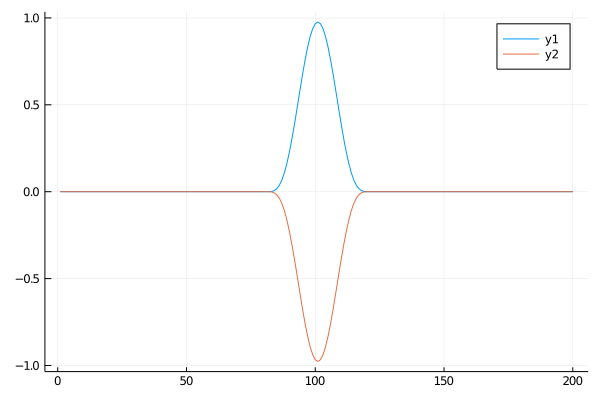

In [5]:
#n = Array(Vector([1.0 for i in 1:N]))
#x = range(0., length=N, step=dx)
#ones = ones(N)

x0 = 0.4; x1 = 0.6
for i in 1:N
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        r0[i,1] = (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250
        r0[i,2] = -r0[i,1]
    end
end

plot(r0)

We define now the two problems, for different accuracy. 

In [6]:
@time prob2 = ODEProblem(F2!,r0,(0.0,T),p);
@time prob4 = ODEProblem(F4!,r0,(0.0,T),p);

  0.362483 seconds (530.36 k allocations: 30.099 MiB, 7.68% gc time)
  0.014161 seconds (27.93 k allocations: 1.698 MiB)


We now solve them:

In [7]:
@time sol2 = solve(prob2,RK4(),dt=dt);

 12.852727 seconds (16.90 M allocations: 9.403 GiB, 12.18% gc time)


In [8]:
@time sol4 = solve(prob4,RK4(),dt=dt);

 20.595909 seconds (11.44 M allocations: 22.282 GiB, 17.40% gc time)


Finally we plot the solutions at different times

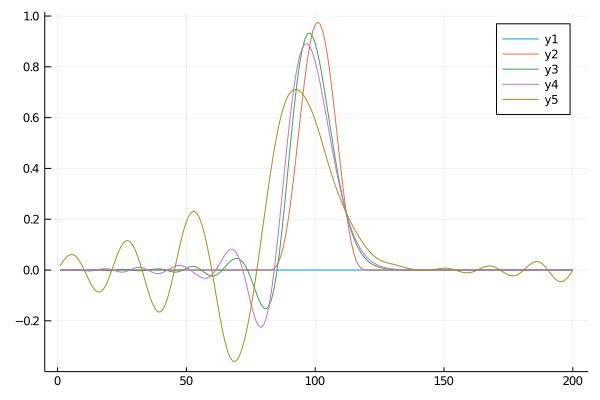

In [25]:
plot([r0[:,1],sol2(T*0.0)[:,1],sol2(T*0.2)[:,1],sol2(T*0.3)[:,1],sol2(T*1)[:,1]])

┌ Info: Saved animation to 
│   fn = /Users/reula/Docencia/PDE2020/pde/Tarea_2/wave_anim_fps20.gif
└ @ Plots /Users/reula/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Docencia/PDE2020/pde/Tarea_2/wave_anim_fps20.gif")
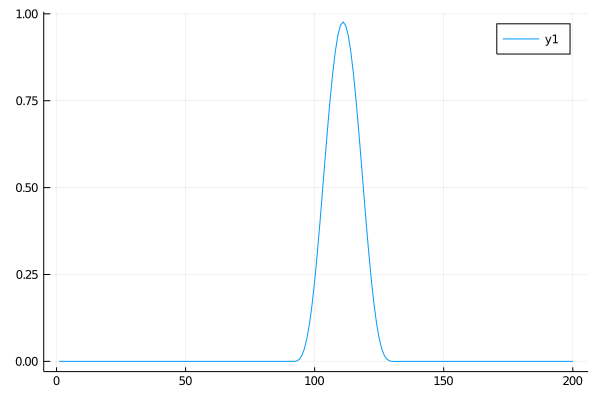

In [11]:
anim = @animate for i ∈ 1:20
    plot(sol4(T*0.005*i)[:,1])
end

gif(anim, "wave_anim_fps20.gif", fps = 20)
    

In [ ]:
plot([r0[:,1],sol2(T)[:,1],sol4(T)[:,1]])
#plot(x,sol.u)